In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from __future__ import print_function
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import sys
import os
import glob

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans)
from sklearn.metrics import (cohen_kappa_score, confusion_matrix, classification_report, f1_score)

# For permutation tests
from sympy.utilities.iterables import multiset_permutations

from MulticoreTSNE import MulticoreTSNE as MTSNE

# config = tf.ConfigProto( device_count = {'GPU': 0} )

colors = [ 'firebrick', 'olivedrab', 'blueviolet', 'goldenrod', 'lightsalmon' ]
labels = ['G3', 'G4', 'G5', 'BN', 'ST']

In [2]:
# MODULE_URL = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'; MODULE_NAME='InceptionV3'
MODULE_URL = 'https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/1'; MODULE_NAME='NasNet'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1'; MODULE_NAME='Resnet50'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/1'; MODULE_NAME='Resnet101'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/1'; MODULE_NAME='Resnet152'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_050_224/feature_vector/1'; MODULE_NAME='MobilenetV2'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/1'; MODULE_NAME='InceptionResnet'

# config = tf.ConfigProto( device_count = {'GPU': 0} )
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

module = hub.Module(MODULE_URL)
height, width = hub.get_expected_image_size(module)
print(height, width)

image_in = tf.placeholder('float', [1, height, width, 3])
z_op = module(image_in)
sess.run(tf.global_variables_initializer())

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/cell_0/1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/1x1/weights
INFO:tensorflow:Initialize variable module/cell_0/beginning_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/beginning_bn/beta
INFO:tensorflow:Initialize variable module/cell_0/beginning_bn/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/beginning_bn/gamma
INFO:tensorflow:Initialize variable module/cell_0/beginning_bn/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/beginning_bn/moving_mean
INFO:tensorflow:Initialize variable module/cell_0/beginning_bn/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78f

INFO:tensorflow:Initialize variable module/cell_0/comb_iter_1/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_1/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module/cell_0/comb_iter_1/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_1/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_0/comb_iter_1/left/bn_sep_5x5_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_1/left/bn_sep_5x5_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_0/comb_iter_1/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_1/left/separable_5x5_1/depthwise_weights
INFO:tenso

INFO:tensorflow:Initialize variable module/cell_0/final_path_bn/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/final_path_bn/moving_variance
INFO:tensorflow:Initialize variable module/cell_0/path1_conv/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/path1_conv/weights
INFO:tensorflow:Initialize variable module/cell_0/path2_conv/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/path2_conv/weights
INFO:tensorflow:Initialize variable module/cell_1/1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/1x1/weights
INFO:tensorflow:Initialize variable module/cell_1/beginning_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/beginning_bn/beta
INFO

INFO:tensorflow:Initialize variable module/cell_1/comb_iter_1/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_1/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_1/comb_iter_1/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_1/left/bn_sep_5x5_2/beta
INFO:tensorflow:Initialize variable module/cell_1/comb_iter_1/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_1/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module/cell_1/comb_iter_1/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_1/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module

INFO:tensorflow:Initialize variable module/cell_1/prev_1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/prev_1x1/weights
INFO:tensorflow:Initialize variable module/cell_1/prev_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/prev_bn/beta
INFO:tensorflow:Initialize variable module/cell_1/prev_bn/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/prev_bn/gamma
INFO:tensorflow:Initialize variable module/cell_1/prev_bn/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/prev_bn/moving_mean
INFO:tensorflow:Initialize variable module/cell_1/prev_bn/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/prev_bn/moving_variance
INFO:tensorflow:Initiali

INFO:tensorflow:Initialize variable module/cell_10/comb_iter_1/left/bn_sep_5x5_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_1/left/bn_sep_5x5_1/gamma
INFO:tensorflow:Initialize variable module/cell_10/comb_iter_1/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_1/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_10/comb_iter_1/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_1/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_10/comb_iter_1/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_1/left/bn_sep_5x5_2/beta
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_10/comb_iter_4/left/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_4/left/separable_3x3_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_10/comb_iter_4/left/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_4/left/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_10/prev_1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/prev_1x1/weights
INFO:tensorflow:Initialize variable module/cell_10/prev_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/prev_bn/beta
INFO:tensorflow:Initialize variable module/cell_10/prev_bn/gamma:0 from checkpoint /tmp/

INFO:tensorflow:Initialize variable module/cell_11/comb_iter_0/right/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_0/right/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_1/left/bn_sep_5x5_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_1/left/bn_sep_5x5_1/beta
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_1/left/bn_sep_5x5_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_1/left/bn_sep_5x5_1/gamma
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_1/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_1/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initia

INFO:tensorflow:Initialize variable module/cell_11/comb_iter_4/left/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_4/left/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_4/left/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_4/left/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_4/left/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_4/left/separable_3x3_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_4/left/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cel

INFO:tensorflow:Initialize variable module/cell_12/comb_iter_0/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_0/right/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_0/right/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_0/right/separable_3x3_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_0/right/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_0/right/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_1/left/bn_sep_5x5_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_

INFO:tensorflow:Initialize variable module/cell_12/comb_iter_4/left/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_4/left/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_4/left/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_4/left/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_4/left/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_4/left/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_4/left/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_4/left/separa

INFO:tensorflow:Initialize variable module/cell_13/comb_iter_0/right/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_0/right/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_0/right/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_0/right/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_0/right/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_0/right/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_0/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_0/righ

INFO:tensorflow:Initialize variable module/cell_13/comb_iter_4/left/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_4/left/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_4/left/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_4/left/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_4/left/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_4/left/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_4/left/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_4/left/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_14/comb_iter_0/right/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_0/right/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_0/right/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_0/right/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_0/right/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_0/right/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_0/right/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_0/right/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize

INFO:tensorflow:Initialize variable module/cell_14/comb_iter_4/left/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_4/left/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_4/left/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_4/left/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_4/left/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_4/left/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_4/left/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_4/left/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_15/comb_iter_0/right/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_0/right/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_0/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_0/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_0/right/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_0/right/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_0/right/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_0/right/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize

INFO:tensorflow:Initialize variable module/cell_15/comb_iter_1/right/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_1/right/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_4/left/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_4/left/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_4/left/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_4/left/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_4/left/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_4/left/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initia

INFO:tensorflow:Initialize variable module/cell_16/comb_iter_0/right/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_0/right/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_0/right/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_0/right/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_0/right/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_0/right/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_0/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_0/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize

INFO:tensorflow:Initialize variable module/cell_16/comb_iter_1/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_1/right/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_1/right/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_1/right/separable_3x3_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_1/right/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_1/right/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_4/left/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_

INFO:tensorflow:Initialize variable module/cell_17/comb_iter_0/left/separable_5x5_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_0/left/separable_5x5_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_0/left/separable_5x5_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_0/left/separable_5x5_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_0/right/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_0/right/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_0/right/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_0/right/bn_sep_3x3_1/gamma
IN

INFO:tensorflow:Initialize variable module/cell_17/comb_iter_1/right/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_1/right/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_1/right/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_1/right/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_1/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_1/right/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_1/right/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1

INFO:tensorflow:Initialize variable module/cell_2/comb_iter_0/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_0/left/separable_5x5_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_0/left/separable_5x5_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_0/left/separable_5x5_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_0/left/separable_5x5_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_0/left/separable_5x5_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_0/left/separable_5x5_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/com

INFO:tensorflow:Initialize variable module/cell_2/comb_iter_1/right/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_1/right/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_1/right/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_1/right/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_1/right/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_1/right/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_1/right/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_1/right/separable_3x3_1/depthwise_weights
IN

INFO:tensorflow:Initialize variable module/cell_3/comb_iter_0/left/bn_sep_5x5_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_0/left/bn_sep_5x5_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_0/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_0/left/separable_5x5_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_0/left/separable_5x5_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_0/left/separable_5x5_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_0/left/separable_5x5_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_0/l

INFO:tensorflow:Initialize variable module/cell_3/comb_iter_1/right/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_1/right/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_1/right/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_1/right/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_1/right/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_1/right/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_1/right/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_1/right/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_4/comb_iter_0/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_0/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_0/left/bn_sep_5x5_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_0/left/bn_sep_5x5_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_0/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_0/left/separable_5x5_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_0/left/separable_5x5_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_0/left/separable_5x5_

INFO:tensorflow:Initialize variable module/cell_4/comb_iter_1/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_1/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_1/right/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_1/right/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_1/right/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_1/right/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_1/right/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_1/right/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_5/comb_iter_0/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_0/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_0/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_0/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_0/left/bn_sep_5x5_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_0/left/bn_sep_5x5_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_0/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_0/left/separable_5x5_1/depthwise_weights
INFO:tenso

INFO:tensorflow:Initialize variable module/cell_5/comb_iter_1/right/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_1/right/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_1/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_1/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_1/right/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_1/right/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_1/right/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_1/right/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_6/comb_iter_0/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_0/left/bn_sep_5x5_2/beta
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_0/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_0/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_0/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_0/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_0/left/bn_sep_5x5_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_0/left/bn_sep_5x5_2/moving_variance
INFO:tensorflow:Initialize variable module

INFO:tensorflow:Initialize variable module/cell_6/comb_iter_1/right/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_1/right/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_1/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_1/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_1/right/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_1/right/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_1/right/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_1/right/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_7/comb_iter_0/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_0/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_0/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_0/left/bn_sep_5x5_2/beta
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_0/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_0/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_0/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_0/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module

INFO:tensorflow:Initialize variable module/cell_7/comb_iter_1/right/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_1/right/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_1/right/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_1/right/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_1/right/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_1/right/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_1/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_1/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_8/comb_iter_0/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_0/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_0/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_0/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_0/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_0/left/bn_sep_5x5_2/beta
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_0/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_0/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module

INFO:tensorflow:Initialize variable module/cell_8/comb_iter_1/right/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_1/right/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_1/right/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_1/right/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_1/right/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_1/right/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_1/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_1/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_9/comb_iter_0/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_0/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_0/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_0/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_0/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_0/left/bn_sep_5x5_2/beta
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_0/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_0/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module

INFO:tensorflow:Initialize variable module/cell_9/comb_iter_1/right/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_1/right/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_1/right/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_1/right/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_1/right/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_1/right/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_1/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_1/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/gamma
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_0/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_0/left/bn_sep_5x5_2/beta
IN

INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_1/right/separable_7x7_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_1/right/separable_7x7_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_1/right/separable_7x7_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_1/right/separable_7x7_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_1/right/separable_7x7_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_1/right/separable_7x7_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_2/right/bn_sep_5x5_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables

INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_0/left/bn_sep_5x5_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_0/left/bn_sep_5x5_1/gamma
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_0/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_0/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_0/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_0/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_0/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_0/left/bn_sep_5x5_2/beta
IN

INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_1/right/separable_7x7_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_1/right/separable_7x7_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_1/right/separable_7x7_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_1/right/separable_7x7_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_1/right/separable_7x7_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_1/right/separable_7x7_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_2/right/bn_sep_5x5_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables

INFO:tensorflow:Initialize variable module/conv0/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with conv0/weights
INFO:tensorflow:Initialize variable module/conv0_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with conv0_bn/beta
INFO:tensorflow:Initialize variable module/conv0_bn/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with conv0_bn/gamma
INFO:tensorflow:Initialize variable module/conv0_bn/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with conv0_bn/moving_mean
INFO:tensorflow:Initialize variable module/conv0_bn/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with conv0_bn/moving_variance
INFO:tensorflow:Initialize variable module/reduction_cell_0/1x1/weights:0 from checkpoint /t

INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_1/right/bn_sep_7x7_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_1/right/bn_sep_7x7_1/beta
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_1/right/bn_sep_7x7_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_1/right/bn_sep_7x7_1/gamma
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_1/right/bn_sep_7x7_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_1/right/bn_sep_7x7_1/moving_mean
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_1/right/bn_sep_7x7_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/c

INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_4/left/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_4/left/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_4/left/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_4/left/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_4/left/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_4/left/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_4/left/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743

INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_0/right/bn_sep_7x7_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_0/right/bn_sep_7x7_2/moving_mean
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_0/right/bn_sep_7x7_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_0/right/bn_sep_7x7_2/moving_variance
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_0/right/separable_7x7_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_0/right/separable_7x7_1/depthwise_weights
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_0/right/separable_7x7_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9

INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_4/left/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_4/left/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_4/left/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_4/left/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_4/left/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_4/left/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_4/left/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell

In [4]:
allvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
print(len(allvars))
nparam = 0
for var in allvars:
    nparm = np.prod(var.get_shape())
    nparam += nparm
    print(var.name, var.get_shape(), nparm, nparam)
    
print(nparam)

1544
module/conv0/weights:0 (3, 3, 3, 96) 2592 2592
module/cell_stem_0/1x1/weights:0 (1, 1, 96, 42) 4032 6624
module/cell_stem_0/comb_iter_0/left/separable_5x5_1/depthwise_weights:0 (5, 5, 42, 1) 1050 7674
module/cell_stem_0/comb_iter_0/left/separable_5x5_1/pointwise_weights:0 (1, 1, 42, 42) 1764 9438
module/cell_stem_0/comb_iter_0/left/separable_5x5_2/depthwise_weights:0 (5, 5, 42, 1) 1050 10488
module/cell_stem_0/comb_iter_0/left/separable_5x5_2/pointwise_weights:0 (1, 1, 42, 42) 1764 12252
module/cell_stem_0/comb_iter_0/right/separable_7x7_1/depthwise_weights:0 (7, 7, 96, 1) 4704 16956
module/cell_stem_0/comb_iter_0/right/separable_7x7_1/pointwise_weights:0 (1, 1, 96, 42) 4032 20988
module/cell_stem_0/comb_iter_0/right/separable_7x7_2/depthwise_weights:0 (7, 7, 42, 1) 2058 23046
module/cell_stem_0/comb_iter_0/right/separable_7x7_2/pointwise_weights:0 (1, 1, 42, 42) 1764 24810
module/cell_stem_0/comb_iter_1/right/separable_7x7_1/depthwise_weights:0 (7, 7, 96, 1) 4704 29514
module/cel

module/cell_8/comb_iter_1/left/separable_5x5_2/pointwise_weights:0 (1, 1, 336, 336) 112896 11948154
module/cell_8/comb_iter_1/right/separable_3x3_1/depthwise_weights:0 (3, 3, 336, 1) 3024 11951178
module/cell_8/comb_iter_1/right/separable_3x3_1/pointwise_weights:0 (1, 1, 336, 336) 112896 12064074
module/cell_8/comb_iter_1/right/separable_3x3_2/depthwise_weights:0 (3, 3, 336, 1) 3024 12067098
module/cell_8/comb_iter_1/right/separable_3x3_2/pointwise_weights:0 (1, 1, 336, 336) 112896 12179994
module/cell_8/comb_iter_4/left/separable_3x3_1/depthwise_weights:0 (3, 3, 336, 1) 3024 12183018
module/cell_8/comb_iter_4/left/separable_3x3_1/pointwise_weights:0 (1, 1, 336, 336) 112896 12295914
module/cell_8/comb_iter_4/left/separable_3x3_2/depthwise_weights:0 (3, 3, 336, 1) 3024 12298938
module/cell_8/comb_iter_4/left/separable_3x3_2/pointwise_weights:0 (1, 1, 336, 336) 112896 12411834
module/cell_9/prev_1x1/weights:0 (1, 1, 2016, 336) 677376 13089210
module/cell_9/1x1/weights:0 (1, 1, 2016, 336)

## Populate a matrix of feature vectors

In [6]:
jpg_list = sorted(glob.glob('../data/jpg/*.jpg'))
mask_list = sorted(glob.glob('../data/mask/*.png'))

img_classes = []
orig_imgs = []

z_vectors = []
idx = 0

resize = 1.
# resize = 0.5
# resize = 0.25
crop_size = int(height * (1/resize))

samples = 10
x0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)
y0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)
coords = zip(x0_vect, y0_vect)

for img_idx, (jpg, mask) in enumerate(zip(jpg_list, mask_list)):
    y = cv2.imread(mask, -1)
    x = cv2.imread(jpg, -1)[:,:,::-1]
               
    for k in range(samples):
        x0 = np.random.randint(0, 1200-crop_size)
        y0 = np.random.randint(0, 1200-crop_size)
        
        ## Grab the majority label
        y_ = y[x0:x0+crop_size, y0:y0+crop_size]
        totals = np.zeros(5)
        for k in range(5):
            totals[k] = (y_==k).sum()

        # Check for majority
        maj = np.argmax(totals)   
        if totals[maj] > 0.5 * (crop_size**2):
            # check for stroma -- two ways to skip stroma
            if maj==4 and totals[maj] < 0.95 * (crop_size*2):
                continue
#             elif maj==4 and np.random.randn(1) < 0.5:
            elif maj==4 and np.random.choice([0,1], p=[0.1, 0.9]):
                continue
        else:
            continue

        img_classes.append(maj)
        orig_imgs.append(img_idx)
        idx += 1
        if idx % 250 == 0:
            print('[{} / {}]'.format(img_idx, len(jpg_list)))
        x_ = x[x0:x0+crop_size, y0:y0+crop_size, :]
        x_ = cv2.resize(x_, dsize=(0,0), fx=resize, fy=resize)
        x_ = x_ * (1/255.)
        x_ = np.expand_dims(x_, 0)
        
        z = sess.run(z_op, feed_dict={image_in: x_})

        z_vectors.append(z)
    
    
z_vectors = np.concatenate(z_vectors, axis=0)

img_classes = np.asarray(img_classes)
orig_imgs = np.asarray(orig_imgs)
print('z vectors', z_vectors.shape)
print('img classes', img_classes.shape)
print('got classes:', np.unique(img_classes))

manifold = MTSNE(n_jobs=8, n_components=2, verbose=1)
z_manifold = manifold.fit_transform(z_vectors)
print('z manifold', z_manifold.shape)

[48 / 625]
[200 / 625]
[227 / 625]
[254 / 625]
[284 / 625]
[317 / 625]
[379 / 625]
[435 / 625]
[473 / 625]
[527 / 625]
[573 / 625]
[620 / 625]
z vectors (3035, 2048)
img classes (3035,)
got classes: [0 1 2 3 4]
z manifold (3035, 2)


## Cluter the z vectors

In [7]:
# Compare label assignments with the annotation
# clustered = clusterer.labels_

max_kappa = 0.0
max_f1 = 0.0
best_remapped = None

for vers in range(10):
    clusterer = MiniBatchKMeans(n_clusters=5, verbose=0, n_init=100).fit(z_vectors)
    clustered = clusterer.labels_
    
    for perm in multiset_permutations(range(5)):
        # Pick a mapping clustered --> labels
        mapping = {x: k for x, k in zip(range(5), perm)}

        clustered_remapped = np.asarray([mapping[y] for y in clustered])

        kappa = cohen_kappa_score(img_classes, clustered_remapped)
        f1 = f1_score(img_classes, clustered_remapped, average='weighted')
# 
#         print(vers, f1, max_f1)
#         if kappa > max_kappa:
        if f1 > max_f1:
            best_remapped = clustered_remapped
            max_kappa = kappa
            max_f1 = f1
            print(vers, kappa, f1)
            print(mapping)
            print(classification_report(img_classes, clustered_remapped), end='\n\n')

0 0.14800520023566188 0.341795503393631
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
             precision    recall  f1-score   support

          0       0.04      0.05      0.04       461
          1       0.56      0.33      0.41      1344
          2       0.29      0.45      0.36       546
          3       0.21      0.19      0.20       361
          4       0.49      0.77      0.60       323

avg / total       0.38      0.34      0.34      3035


0 0.1919576597308129 0.3529341834664095
{0: 1, 1: 0, 2: 2, 3: 3, 4: 4}
             precision    recall  f1-score   support

          0       0.22      0.37      0.28       461
          1       0.61      0.26      0.36      1344
          2       0.29      0.45      0.36       546
          3       0.21      0.19      0.20       361
          4       0.49      0.77      0.60       323

avg / total       0.43      0.36      0.35      3035


0 0.18973024205612765 0.365813006180646
{0: 2, 1: 1, 2: 0, 3: 3, 4: 4}
             precision    recall  f1-

Text(0.5,0.98,'Resnet152 (resize=1.0)\nf1=0.438')

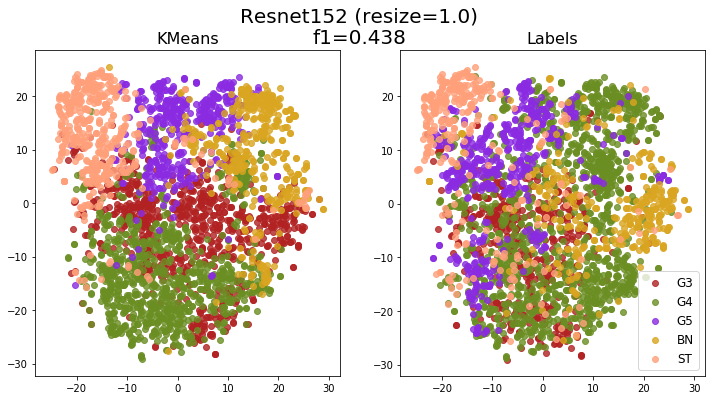

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))

for k in range(5):
    idxs = np.where(best_remapped==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], ax=axs[0])
    
    idxs = np.where(img_classes==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], label=labels[k], ax=axs[1])

axs[0].set_title('KMeans', fontsize=16)
axs[1].set_title('Labels', fontsize=16)
plt.legend(fontsize=12)
# plt.suptitle(u'{}\n$\kappa={:3.3f}$'.format(MODULE_NAME, max_kappa), fontsize=20)
plt.suptitle('{} (resize={})\nf1={:3.3f}'.format(MODULE_NAME, resize, max_f1), fontsize=20)
# plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/{}_kmeans.pdf'.format(MODULE_NAME), bbox_inches='tight')